In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [2]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

from transformers import AutoTokenizer
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

In [3]:
# Functions for modifying datasets, to prepare them for futher use
def modify_df(df):
    df.rename(columns={"span": "aspect"}, inplace=True)
    df = df[['text', 'aspect', 'label']]
    df = df[df["label"] != "conflict"]
    df = df.dropna()
    return df

def modify_dfCz(df):
    df.rename(columns={"aspectTerms__aspectTerm__@polarity": "label", "aspectTerms__aspectTerm__@term": "aspect"}, inplace=True)
    df = df[['text', 'aspect', 'label']]
    df = df[df["label"] != "conflict"]
    df['text'] = df['text'].fillna(method='ffill')
    df = df.dropna()
    return df

[Aspect-Level Sentiment Analysis in Czech](https://aclanthology.org/W14-2605/) (Steinberger et al., WASSA 2014)

In [4]:
#Dataset downloaded from https://corpora.kiv.zcu.cz/sentiment/
dfCzechRes = pd.read_csv("/content/drive/MyDrive/Newton/CzechRestaurants/data/CzechABSA-SemEval2014.csv")

[SemEval-2014 Task 4: Aspect Based Sentiment Analysis](https://aclanthology.org/S14-2004/) (Pontiki et al., SemEval 2014)

In [5]:
#Dataset from https://huggingface.co/datasets/tomaarsen/setfit-absa-semeval-laptops
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
dfEngLap = pd.read_parquet("hf://datasets/tomaarsen/setfit-absa-semeval-laptops/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
#Dataset from https://huggingface.co/datasets/tomaarsen/setfit-absa-semeval-restaurants
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
dfEngRes = pd.read_parquet("hf://datasets/tomaarsen/setfit-absa-semeval-restaurants/" + splits["train"])

In [7]:
dfCzechRes = modify_dfCz(dfCzechRes)
dfEngLap = modify_df(dfEngLap)
dfEngRes = modify_df(dfEngRes)

<ipython-input-3-eefb63f53733>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['text'] = df['text'].fillna(method='ffill')


In [13]:
dfCzechMed = pd.read_csv("/content/drive/MyDrive/Newton/CzechMedia/data/dataset.csv")

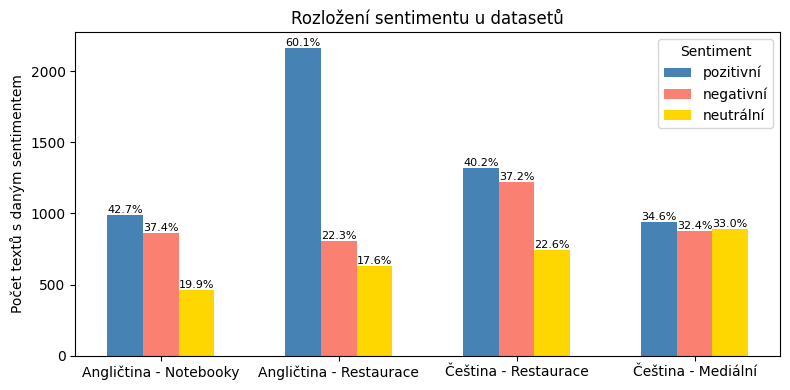

In [14]:
# Graph for ploting the distribution in label for each dataset
label2id = {"negative": "negativní", "neutral": "neutrální", "positive": "pozitivní"}
dfEngLap["labelCZ"] = dfEngLap["label"].apply(lambda x: label2id[x])
dfEngRes["labelCZ"] = dfEngRes["label"].apply(lambda x: label2id[x])
dfCzechRes["labelCZ"] = dfCzechRes["label"].apply(lambda x: label2id[x])
dfCzechMed["labelCZ"] = dfCzechMed["label"].apply(lambda x: label2id[x])

datasets = {
    "Angličtina - Notebooky": dfEngLap,
    "Angličtina - Restaurace": dfEngRes,
    "Čeština - Restaurace": dfCzechRes,
    "Čeština - Mediální": dfCzechMed
}

sent_labels = ["pozitivní", "negativní", "neutrální"]
colors = {"pozitivní":"steelblue", "negativní":"salmon", "neutrální":"gold"}

data = {name: d["labelCZ"].value_counts().reindex(sent_labels, fill_value=0)
        for name, d in datasets.items()}
counts = pd.DataFrame(data).T
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(8,4))

bar_width = 0.20
x = range(len(datasets))

for i, sent in enumerate(sent_labels):
    # Plot bar for each sentiment
    bars = ax.bar([p + i * bar_width for p in x],
                  counts[sent],
                  width=bar_width,
                  color=colors[sent],
                  label=sent)

    # For each bar, plot a precentual number over the top, to represent the coverage of that label
    for j, bar in enumerate(bars):
        height = bar.get_height()
        percentage = percentages[sent].iloc[j]
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%',
                ha='center', va='bottom', fontsize=8, color='black')

ax.set_xticks([p + bar_width for p in x])
ax.set_xticklabels(counts.index)
ax.set_ylabel("Počet textů s daným sentimentem")
ax.set_title("Rozložení sentimentu u datasetů")
ax.legend(title="Sentiment")
plt.tight_layout()
plt.show()